In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
GTZAN_DIR_PATH = '/content/drive/MyDrive/ColabNotebooks'
GTZAN_GENRES = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# BEGIN MY IMPLEMENTATION
### Import Packages & Set Global Variables


In [ ]:
import torch, torchvision
import torchaudio
from torchaudio import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import os
import numpy as np
import torch.nn as nn
import torch.distributions as dist
from librosa.effects import pitch_shift


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GTZAN_DIR_PATH = '/content/drive/MyDrive/CS 682/682 Final Project'
GENRES_DIR = GTZAN_DIR_PATH + "/genres"
MELSPEC_GENRES_DIR = GTZAN_DIR_PATH + "/melspec_genres"
GENRES_TRAIN = GTZAN_DIR_PATH + "/genres_train"
GENRES_TEST = GTZAN_DIR_PATH + "/genres_test"
MODELS_DIR = GTZAN_DIR_PATH + "/models"

if not os.path.exists(MODELS_DIR): os.makedirs(MODELS_DIR)

### Data Preprocessing

In [ ]:
'''

'''
def addNoiseAugmentation(waveform, noise_amplitude):
  noise = torch.randn(waveform.shape)
  noisy_waveform = waveform + noise * noise_amplitude
  return noisy_waveform

def pitchShiftAugmentation(waveform, sample_rate):
  n_steps = (torch.rand(1) * 8 - 4).item() #n_steps in [-4, 4] uniform dist
  return torch.from_numpy(pitch_shift(waveform.numpy(), sr=sample_rate, n_steps=n_steps))

def wav_2_melspec(path, pitchShift, addNoise, noise_amplitude):
  waveform, sample_rate = torchaudio.load(path, normalize=True)
  waveforms = [(waveform, "")]

  if addNoise:
    waveforms.append((addNoiseAugmentation(waveform, noise_amplitude), "addNoise"))

  if pitchShift:
    waveforms.append((pitchShiftAugmentation(waveform, sample_rate), "pitchShift"))

  transform = transforms.MelSpectrogram(sample_rate)
  melspecs = []
  for waveform in waveforms:
    melspec = transform(waveform[0])[:, :, :3300]
    melspecs.append((melspec, waveform[1])) #some files are smaller, so we cut at 3300

  return melspecs

def preprocess_melspecs(trainingPathEnding = "", pitchShift=False, addNoise=False, noise_amplitude = 0.001):
  if len(trainingPathEnding) > 0:
    trainingPathEnding = "_" + trainingPathEnding
  for genre in os.listdir(GENRES_DIR):
    #### IGNORE .DS_Store ####
    genre_dir = os.path.join(GENRES_DIR,genre)
    genre_train_dir = os.path.join(GENRES_TRAIN + trainingPathEnding, genre)
    genre_test_dir = os.path.join(GENRES_TEST, genre)

    #### ADD DIRECTORIES ####
    if not os.path.isdir(genre_dir): continue

    if not os.path.exists(genre_train_dir):
      os.makedirs(genre_train_dir)

    if not os.path.exists(genre_test_dir):
      os.makedirs(genre_test_dir)

    #### CREATE TEST AND TRAIN SETS ####
    files = os.listdir(genre_dir)
    num_test = int(len(files) * 0.3)
    test_files = np.array([True] * num_test + [False] * (len(files) - num_test))
    np.random.shuffle(test_files)

    for i, file in enumerate(files):
      if ".wav" not in file: continue

      #### GENERATE BASE MELSPEC & AUGMENTATION MELSPECS ####
      file_path = os.path.join(genre_dir,file)
      melspecs = wav_2_melspec(file_path, pitchShift=pitchShift, addNoise=addNoise, noise_amplitude=noise_amplitude)

      #### SAVE MELSPECS ####
      if test_files[i]:
        output_path = os.path.join(genre_test_dir, os.path.basename(file_path)[:-4] + "_" + melspecs[0][1] + ".npy")
        np.save(output_path, melspecs[0][0].numpy())
      else:
        for melspec in melspecs:
          output_path = os.path.join(genre_train_dir, os.path.basename(file_path)[:-4] + "_" + melspec[1] + ".npy")
          np.save(output_path, melspec[0].numpy())

#TODO: Uncomment next line to create test and training melspectrograms
preprocess_melspecs(trainingPathEnding="all", pitchShift=True, addNoise=True)

### Create Dataset

In [ ]:
from torch.utils.data import Dataset

class MelspecDataset(Dataset):
  '''
  root_dir: directory containing melspec genre subdirectories
  splits: number of images to generate from each spectrogram
  split_ranges: start time and end time for each audio split
  '''
  def __init__(self, root_dir, num_splits=1, W=3300, num_mixup=0):
    self.root_dir = root_dir
    self.genres = os.listdir(self.root_dir)
    self.file_paths = []
    self.split_ranges = []
    self.labels = []
    self.num_splits = num_splits



    for id, genre in enumerate(os.listdir(self.root_dir)):
      genre_dir = os.path.join(root_dir, genre)
      if not os.path.isdir(genre_dir): continue
      mel_paths = [os.path.join(genre_dir, file) for file in os.listdir(genre_dir) if ".npy" in file]
      #repeat the path and labels for each split
      split_mel_paths = [path for path in mel_paths for _ in range(num_splits)]
      self.file_paths.extend(split_mel_paths)
      self.labels.extend([torch.eye(len(self.genres))[id]] * len(split_mel_paths))
      self.split_ranges.extend([(i*W//num_splits, (i+1)*W//num_splits) for i in range(num_splits)] * len(mel_paths))

    self.mixup_indexes, self.mixup_labels, self.lams = self.setMixupPairings(num_mixup)


  def setMixupPairings(self, num_mixup):
    # Welcome to funky town!
    '''
    mixup_indexes: (index_to_file1, index_to_file2)
    lam = mixed_factor
      x' = lam*x_1 + (1-lam)x_2
      y' = lam*y_1 + (1-lam)y_2
    '''
    mixup_indexes = []
    mixup_labels = []
    lams = []
    for _ in range(num_mixup):
      # alpha is value in (0, inf)
      alpha = torch.rand(1).item()
      # value in Beta(alpha, alpha)
      lam = dist.Beta(alpha, alpha).sample().item()

      rand_index1 = torch.randint(0, len(self.file_paths), (1,)).item()
      rand_index2 = torch.randint(0, len(self.file_paths), (1,)).item()
      mixup_indexes.append((rand_index1, rand_index2))
      mixup_labels.append(lam * self.labels[rand_index1] + (1- lam) * self.labels[rand_index2])
      lams.append(lam)
    return mixup_indexes, mixup_labels, lams



  def __len__(self):
    return len(self.labels) + len(self.mixup_labels)

  def __getitem__(self, idx):
    #This is a horrible way to do mixup, but that's just the way it goes sometimes :)
    label = None
    melspec = None

    if idx < len(self.file_paths):
      melspec_path = self.file_paths[idx]
      melspec = torch.from_numpy(np.load(melspec_path)[:, :, self.split_ranges[idx][0] : self.split_ranges[idx][1]])
      label = self.labels[idx]
    else:
    #We compute mixup
      #wrap around idx for mixup indexes
      idx -= len(self.file_paths)
      #get
      i1, i2 = self.mixup_indexes[idx]
      melspec_path1 = self.file_paths[i1]
      melspec_path2 = self.file_paths[i2]
      melspec1 = torch.from_numpy(np.load(melspec_path1)[:, :, self.split_ranges[i1][0] : self.split_ranges[i1][1]])
      melspec2 = torch.from_numpy(np.load(melspec_path2)[:, :, self.split_ranges[i2][0] : self.split_ranges[i2][1]])
      lam = self.lams[idx]
      melspec = lam * melspec1 + (1- lam) * melspec2
      label = self.mixup_labels[idx]
    return melspec, label

H = 128
W= 3300
num_splits = 10
d_train = MelspecDataset(GENRES_TRAIN + "_all", num_splits)
# print(d_train[7001])
d_test = MelspecDataset(GENRES_TEST, num_splits)

## Implement ResNet18

In [ ]:
class ResNetMelspec(nn.Module):
  def __init__(self, dataloader, num_genres, lr=0.001, weight_decay=1e-6, max_iterations=20):
    super(ResNetMelspec, self).__init__()

    self.resnet18 = models.resnet18()#, num_classes=len(d.genres))
    self.resnet18.fc = nn.Linear(self.resnet18.fc.in_features, num_genres) #set output to # of genres
    self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    self.dataloader = dataloader
    self.lr=lr
    self.weight_decay=weight_decay
    self.max_iterations = max_iterations
    self.loss = nn.CrossEntropyLoss()


  def predict(self, x):
    return self.resnet18(x)

  #takes in all splits of a specific MelSpectrogram, outputs class guess
  def predict_full_class(self, x):
    predictions = self.predict(x)
    max_values, _ = torch.max(predictions, dim=1, keepdim=True)
    max_values = torch.eq(max_values, predictions).int()
    # print("max_values:", max_values)
    max_class = torch.argmax(torch.sum(max_values, dim=0))
    return max_class


  def fit(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    for i in range(self.max_iterations):
      loss_sum = 0
      # testing = 0
      for X, labels in self.dataloader:
        X = X.to(device)
        labels = labels.to(device)
        predictions = self.predict(X)
        loss = self.loss(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print("Loss:", loss)
        # if(testing %10 ==  0):
        #   stop = input()
        #   if stop == '1':
        #     return
        loss_sum += loss
        print("Loss:", loss)

      print("Epoch:", i)
      print("Loss:", loss_sum)
      self.save("R2Epoch" + str(i))


  def save(self, name):
    torch.save({'model_state_dict': self.state_dict()}, MODELS_DIR + "/"  + name + ".pt")


  def load(self, name):
    print(MODELS_DIR + "/" + name + ".pt")
    checkpoint = torch.load(MODELS_DIR + "/" + name + ".pt")
    self.load_state_dict(checkpoint["model_state_dict"])

### Initialize Dataloaders

In [ ]:
train_dataloader = DataLoader(d_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=num_splits, shuffle=False)

### Train and Save ResNet


In [ ]:
print(len(train_dataloader))
resNetMelspec = ResNetMelspec(train_dataloader, num_genres=len(d_train.genres)).to(device)
resNetMelspec.fit()
resNetMelspec.save("ResNet_1")

### Test ResNet

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

SAVE_FILE_NAME = "Epoch8" #Ex: "Epoch8"
test_dataloader = DataLoader(d_test, batch_size=num_splits, shuffle=False)
#LOAD FROM FILE
resNetMelspecTest = ResNetMelspec(test_dataloader, num_genres=len(d_test.genres))
resNetMelspecTest.load(SAVE_FILE_NAME)

y_true = []
y_pred = []
count = len(test_dataloader)
with torch.no_grad():
  for x, label in test_dataloader:
    y_true.append(torch.argmax(label).item())
    y_pred.append(resNetMelspecTest.predict_full_class(x).item())

NameError: ignored

0.16333333333333333


<Axes: >

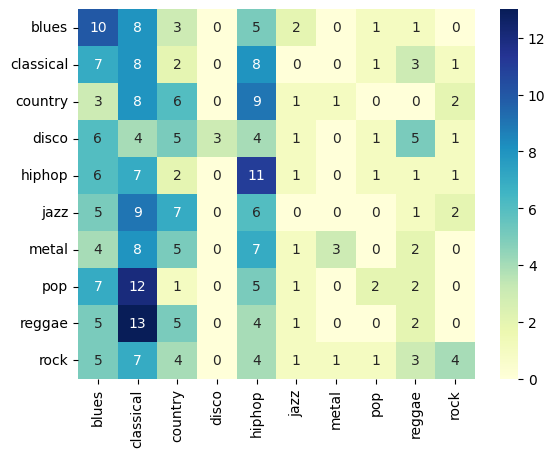

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')

## Implement Paper Model

In [ ]:
import torch
import torch.nn as nn


class Conv_2d_Wrapper(nn.Module):
    def __init__(self, input_channels, output_channels, shape=3, pooling=2, dropout=0.5):
        super(Conv_2d_Wrapper, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=shape, padding=0) #shape//2)
        #self.bn = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(pooling)
        self.dropout = nn.Dropout(dropout)

    def forward(self, wav):
        out = self.conv(wav)
        #out = self.bn(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.dropout(out)
        return out


class KCNN(nn.Module):
    def __init__(self, dataloader,
                       sample_rate=22050,
                       n_fft=1024,
                       f_min=0.0,
                       f_max=11025.0,
                       num_mels=128,
                       num_classes=10, lr=0.001, weight_decay=1e-6, max_iterations=20):
        super(KCNN, self).__init__()

        self.input_bn = nn.BatchNorm2d(1)

        # convolutional layers
        self.layer1 = Conv_2d_Wrapper(1, 128)
        self.layer2 = Conv_2d_Wrapper(128, 64)
        self.layer3 = Conv_2d_Wrapper(64, 32)
        self.layer4 = Conv_2d_Wrapper(32, 16)
        self.layer5 = Conv_2d_Wrapper(16, 8)

        # dense layers
        self.dense1 = nn.Linear(128, num_classes)

        self.dataloader = dataloader
        self.lr=lr
        self.weight_decay=weight_decay
        self.max_iterations = max_iterations
        self.loss = nn.CrossEntropyLoss()

    def forward(self, mel):
       # print(mel.shape)
        # input batch normalization
        #out = mel.unsqueeze(1)
        # out = self.input_bn(out) # input normalization
        # convolutional layers
        out = self.layer1(mel)
        #print(out.shape)
        out = self.layer2(out)
       # print(out.shape)
        out = self.layer3(out)
        #print(out.shape)
        out = self.layer4(out)
        #print(out.shape)
        out = self.layer5(out)
        #print(out.shape)
        out = out.reshape(len(out), -1)
        out = self.dense1(out)
        return out


    def predict(self, x):
      return self.forward(x)

    #takes in all splits of a specific MelSpectrogram, outputs class guess
    def predict_full_class(self, x):
      predictions = self.predict(x)
      max_values, _ = torch.max(predictions, dim=1, keepdim=True)
      max_values = torch.eq(max_values, predictions).int()
      max_class = torch.argmax(torch.sum(max_values, dim=0))
      return max_class


    def fit(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
      for i in range(self.max_iterations):
        loss_sum = 0
        # testing = 0
        for X, labels in self.dataloader:
          X = X.to(device)
          labels = labels.to(device)
          predictions = self.predict(X)
          loss = self.loss(predictions, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          # print("Loss:", loss)
          # if(testing %10 ==  0):
          #   stop = input()
          #   if stop == '1':
          #     return
          loss_sum += loss
          print("Loss:", loss)

        print("Epoch:", i)
        print("Loss:", loss_sum)
        self.save("R2Epoch" + str(i))


    def save(self, name):
      torch.save({'model_state_dict': self.state_dict()}, MODELS_DIR + "/"  + name + ".pt")


    def load(self, name):
      print(MODELS_DIR + "/" + name + ".pt")
      checkpoint = torch.load(MODELS_DIR + "/" + name + ".pt")
      self.load_state_dict(checkpoint["model_state_dict"])

### Initialize Dataloaders

(Repeated from above for the sake of convenience)

In [ ]:
train_dataloader = DataLoader(d_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=num_splits, shuffle=False)

### Load and Train Paper Model

In [ ]:
kcnn = KCNN(train_dataloader).to(device)
kcnn.fit()
kcnn.save("KCNN_1")

Loss: tensor(16.4736, grad_fn=<DivBackward1>)
Loss: tensor(4.9047, grad_fn=<DivBackward1>)
Loss: tensor(4.3584, grad_fn=<DivBackward1>)
Loss: tensor(3.5330, grad_fn=<DivBackward1>)
Loss: tensor(3.7316, grad_fn=<DivBackward1>)
Loss: tensor(2.7665, grad_fn=<DivBackward1>)
Loss: tensor(2.7258, grad_fn=<DivBackward1>)
Loss: tensor(2.5765, grad_fn=<DivBackward1>)
Loss: tensor(2.7749, grad_fn=<DivBackward1>)
Loss: tensor(2.7380, grad_fn=<DivBackward1>)
Loss: tensor(2.5242, grad_fn=<DivBackward1>)
Loss: tensor(2.7366, grad_fn=<DivBackward1>)
Loss: tensor(2.3398, grad_fn=<DivBackward1>)
Loss: tensor(2.5056, grad_fn=<DivBackward1>)
Loss: tensor(2.3867, grad_fn=<DivBackward1>)
Loss: tensor(2.3608, grad_fn=<DivBackward1>)
Loss: tensor(2.3516, grad_fn=<DivBackward1>)
Loss: tensor(2.5101, grad_fn=<DivBackward1>)
Loss: tensor(2.3267, grad_fn=<DivBackward1>)
Loss: tensor(2.3854, grad_fn=<DivBackward1>)
Loss: tensor(2.3961, grad_fn=<DivBackward1>)
Loss: tensor(2.2505, grad_fn=<DivBackward1>)
Loss: ten

KeyboardInterrupt: ignored

### Test Paper Model

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

SAVE_FILE_NAME = "R2Epoch9" #Ex: "Epoch8"
test_dataloader = DataLoader(d_test, batch_size=num_splits, shuffle=False)
#LOAD FROM FILE
kcnn = KCNN(train_dataloader)
kcnn.load(SAVE_FILE_NAME)

y_true = []
y_pred = []
count = len(test_dataloader)
with torch.no_grad():
  for x, label in test_dataloader:
    y_true.append(torch.argmax(label).item())
    y_pred.append(kcnn.predict_full_class(x).item())

/content/drive/MyDrive/CS 682/682 Final Project/models/R2Epoch9.pt


0.5433333333333333


<Axes: >

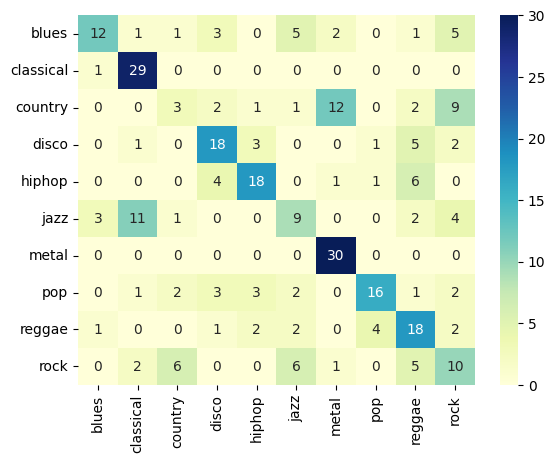

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, xticklabels=GTZAN_GENRES, yticklabels=GTZAN_GENRES, cmap='YlGnBu')
